Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0400 - loss: 2.8302
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3200 - loss: 2.7852
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3200 - loss: 2.7325
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2800 - loss: 2.6621
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2800 - loss: 2.5650
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2400 - loss: 2.4400
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2400 - loss: 2.3292
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2400 - loss: 2.3443
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3200 - loss: 2.3062
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3200 - loss: 2.2225
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3200 - loss: 2.1771
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2800 - loss

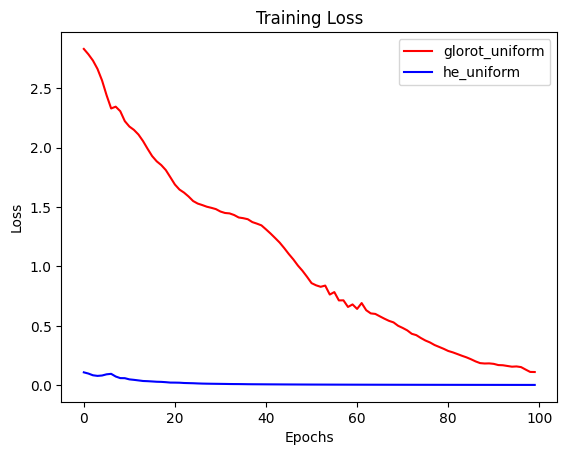

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Wyłączenie optymalizacji OneDNN dla TensorFlow oraz ustawienie poziomu logów
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Budowa warstwy samouwagi (Self-Attention Layer)
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Budowa macierzy wag dla zapytań, kluczy i wartości (Q, K, V)
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linearne projekcje wejść
        q = K.dot(inputs, self.Wq)  # Zapytanie (Query)
        k = K.dot(inputs, self.Wk)  # Klucz (Key)
        v = K.dot(inputs, self.Wv)  # Wartość (Value)

        # Skalowana uwaga poprzez iloczyn skalarny
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Skalowanie
        attention_weights = K.softmax(scores, axis=-1)  # Normalizacja wag uwagi

        # Obliczenie wyjścia jako ważona suma wartości
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

# Przykładowe równoległe zdania (angielski -> hiszpański)
input_texts = [
    "Hello.", "How are you?", "I am learning machine translation.", "What is your name?", "I love programming."
]
target_texts = [
    "Hola.", "¿Cómo estás?", "Estoy aprendiendo traducción automática.", "¿Cuál es tu nombre?", "Me encanta programar."
]

# Dodanie znaczników początkowego i końcowego do zdań docelowych (budowa znakowania)
target_texts = ["startseq " + x + " endseq" for x in target_texts]

# Tokenizacja tekstów wejściowych
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

# Tokenizacja tekstów wyjściowych
output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

# Budowa paddingu dla sekwencji
max_input_length = max([len(seq) for seq in input_sequences])
max_output_length = max([len(seq) for seq in output_sequences])

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

# Przygotowanie danych docelowych do treningu
decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]

# Konwersja danych wyjściowych do formatu one-hot (budowa etykiet)
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Mechanizm uwagi
attention_layer = SelfAttention()(encoder_outputs)

# Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_attention = SelfAttention()(decoder_outputs)  # Zastosowanie mechanizmu uwagi
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_attention)

# Budowa pełnego modelu (Encoder-Decoder)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Trening modelu: porównanie inicjalizatorów glorot_uniform i he_uniform
history_glorot_adam = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)
history_he = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

# Budowa wykresu strat treningowych dla inicjalizatorów glorot_uniform i he_uniform
plt.plot(history_glorot_adam.history['loss'], label="glorot_uniform", color='red')
plt.plot(history_he.history['loss'], label="he_uniform", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
